### (d) Replace the Euclidean metric with the following metrics and test them. Summarize the test errors (i.e., when k = k∗) in a table. Use all of your training data and select the best k when ∈ {1,6,11,...,196}

In [1]:
import numpy as np

CLASS0 = "class 0"
CLASS1 = "class 1"
EPSILON = 1e-8

def load_data(file_path):
	"""read records from csv file"""
	row_data = np.genfromtxt(file_path, dtype=None, delimiter=',', encoding='utf-8')[1:]
	X = np.array(row_data[:, :-1], dtype=float)
	Y_row_str_data = row_data[:, row_data.shape[1] - 1]
	y = np.array([1 if x == "Abnormal" else 0 for x in Y_row_str_data])
	return X, y

def train_test_by_class_index(X, y, split_info_dict):
	"""According to the dict, split row data into X_train, X_test, y_train, y_test"""
	assert X.shape[0] == y.shape[0], \
		"the size of X must be equal to the size of y"
	assert split_info_dict is not None, \
		"Please initialize a dict with {CLASS0: int, CLASS1: int}"
	
	normal_indexes = (y == 0)
	abnormal_indexes = (y == 1)
	normal_limit = split_info_dict[CLASS0]
	abnormal_limit = split_info_dict[CLASS1]

	'''first 70 rows of class 0'''
	X_data_normal = X[normal_indexes, :][:normal_limit]
	y_data_normal = y[normal_indexes][:normal_limit]

	'''the rest of data in class 0'''
	X_rest_data_normal = X[normal_indexes, :][normal_limit:]
	y_rest_data_normal = y[normal_indexes][normal_limit:]

	'''first 140 rows of class 1'''
	X_data_abnormal = X[abnormal_indexes, :][:abnormal_limit]
	y_data_abnormal = y[abnormal_indexes][:abnormal_limit]
	'''the rest of data in class 1'''
	X_rest_data_abnormal = X[abnormal_indexes, :][abnormal_limit:]
	y_rest_data_abnormal = y[abnormal_indexes][abnormal_limit:]

	'''combine them into one array'''
	X_train = np.concatenate((X_data_normal, X_data_abnormal), axis=0)
	X_test = np.concatenate((X_rest_data_normal, X_rest_data_abnormal), axis=0)

	y_train = np.concatenate((y_data_normal, y_data_abnormal), axis=0)
	y_test = np.concatenate((y_rest_data_normal, y_rest_data_abnormal), axis=0)

	return X_train, X_test, y_train, y_test

In [2]:
def accuracy_score(y_true, y_predict):
	'''compare every single item in each array'''
	assert y_true.shape[0] == y_predict.shape[0], \
		"the shape of y_true need to be identical with y_predict"
	return sum(y_true == y_predict) / len(y_true)

In [3]:
# Aaron's KNN based on Minkowski Distance
from math import sqrt
from collections import Counter

class KNeighborsClassifier:

	def __init__(self, n_neighbors, p=2):
		assert n_neighbors >= 1, "n_neighbors must be a valid number"
		self.n_neighbors = n_neighbors
		self.p = p
		self._X_train = None
		self._y_train = None

	def fit(self, X_train, y_train):
		assert X_train.shape[0] == y_train.shape[0], ""
		assert self.n_neighbors <= X_train.shape[0], ""
		self._y_train = y_train
		self._X_train = X_train
		return self

	def predict(self, X_test):
		assert self._X_train is not None and self._y_train is not None, ""
		assert X_test.shape[1] == self._X_train.shape[1], ""

		y_predict = [self._predict(x) for x in X_test]
		return np.array(y_predict)

	def _predict(self, x):
		assert x.shape[0] == self._X_train.shape[1], ""
		# Minkowski Distance metric ==> sum(|x - y|^p)^(1/p)
		distances = [np.sum((abs(item - x) ** self.p)) ** (1 / self.p) for item in self._X_train]
		nearest = np.argsort(distances)
		topK_y = [self._y_train[i] for i in nearest[:self.n_neighbors]]
		votes = Counter(topK_y)

		return votes.most_common(1)[0][0]

	def score(self, X_test, y_test):
		y_predict = self.predict(X_test)
		return accuracy_score(y_test, y_predict)

	def __repr__(self):
		return "KNN(n_neighbors = %d)" % self.n_neighbors

In [4]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### i. Minkowski Distance

####  A. which becomes Manhattan Distance with p = 1.

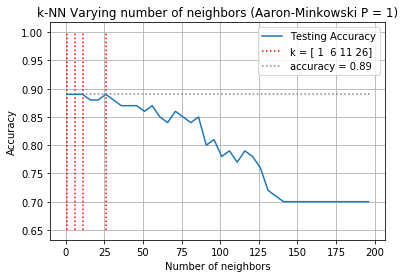

In [5]:
# Test Manhattan Distance when p = 1
X_row_data, Y_row_data = load_data('./assets/data.csv')

split_info_dict = {CLASS0: 70, CLASS1: 140}

# Aaron's split method
X_train, X_test, y_train, y_test = train_test_by_class_index(X_row_data, Y_row_data, split_info_dict)

alternative_k = np.arange(1, 197, 5)
train_accuracy = np.empty(len(alternative_k))
test_accuracy = np.empty(len(alternative_k))

for index, k in enumerate(alternative_k):
    # KNeighborsClassifier based on Aaron's Minkowski Distance
    knn_clf = KNeighborsClassifier(n_neighbors=k, p=1)	# Manhattan Distance
    # knn_clf = KNeighborsClassifier(n_neighbors=k, p=2)  # Euclidean Distance
    # knn_clf = KNeighborsClassifier(n_neighbors=k, p=float('inf'))	# Chebyshev Distance

    knn_clf.fit(X_train, y_train)

    y_predict = knn_clf.predict(X_test)

    train_accuracy[index] = knn_clf.score(X_train, y_train)

    test_accuracy[index] = knn_clf.score(X_test, y_test)

best_accuracy_ = np.max(test_accuracy)
best_k_ = (np.reshape(np.argwhere(test_accuracy == best_accuracy_), (1, -1))[0]) * 5 + 1

plt.title('k-NN Varying number of neighbors (Aaron-Minkowski P = 1)')
plt.plot(alternative_k, test_accuracy, label='Testing Accuracy')
plt.vlines(best_k_, 0.65, 1, colors='red', label='k = ' + str(best_k_),linestyles='dotted')
plt.hlines(best_accuracy_, 0, 197, colors='gray', label='accuracy = ' + str(best_accuracy_), linestyles='dotted')
plt.legend()
plt.grid(True)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

#### B. with log10(p) ∈ {0.1, 0.2, 0.3,....,1}. In this case, use the k∗ you found for the Manhattan distance in 1(d)iA. What is the best log10(p)?

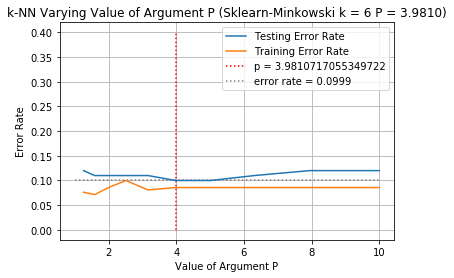

In [6]:
alternative_p = [10 ** p for p in np.arange(0.1, 1.1, 0.1)]
train_accuracy = np.empty(len(alternative_p))
test_accuracy = np.empty(len(alternative_p))

for index, p in enumerate(alternative_p):
    # KNeighborsClassifier based on Minkowski Distance
    # in both sk_minkowski_p1_accurancy and minkowski_p1_accurancy pics, the best k = [1 6 11 26]
    knn_clf = KNeighborsClassifier(n_neighbors=6, p=p)

    knn_clf.fit(X_train, y_train)

    y_predict = knn_clf.predict(X_test)

    train_accuracy[index] = knn_clf.score(X_train, y_train)

    test_accuracy[index] = knn_clf.score(X_test, y_test)

best_accuracy_ = np.max(test_accuracy)
best_p_ = 10 ** (np.argmax(test_accuracy) * 0.1 + 0.1)

plt.title('k-NN Varying Value of Argument P (Sklearn-Minkowski k = 6 P = {})'.format(str(best_p_)[:6]))
plt.plot(alternative_p, 1 - test_accuracy, label='Testing Error Rate')
plt.plot(alternative_p, 1 - train_accuracy, label='Training Error Rate')
plt.vlines(best_p_, 0, 0.4, colors='red', label='p = ' + str(best_p_), linestyles='dotted')
plt.hlines(1 - best_accuracy_, 1, 10, colors='gray', label='error rate = ' + str(1 - best_accuracy_)[:6],
           linestyles='dotted')
plt.legend()
plt.grid(True)
plt.xlabel('Value of Argument P')
plt.ylabel('Error Rate')
plt.show()

#### C. which becomes Chebyshev Distance with p → ∞

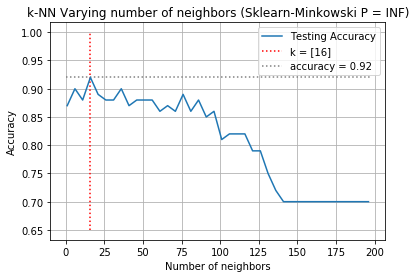

In [7]:
from sklearn.neighbors import KNeighborsClassifier
# Test Minkowski Distance when p = INF
X_row_data, Y_row_data = load_data('./assets/data.csv')

split_info_dict = {CLASS0: 70, CLASS1: 140}

# Aaron's split method
X_train, X_test, y_train, y_test = train_test_by_class_index(X_row_data, Y_row_data, split_info_dict)

alternative_k = np.arange(1, 197, 5)
train_accuracy = np.empty(len(alternative_k))
test_accuracy = np.empty(len(alternative_k))

for index, k in enumerate(alternative_k):
    # KNeighborsClassifier based on Minkowski Distance
    # knn_clf = KNeighborsClassifier(n_neighbors=k, p=1)	# Manhattan Distance
    # knn_clf = KNeighborsClassifier(n_neighbors=k, p=2)  # Euclidean Distance
    knn_clf = KNeighborsClassifier(n_neighbors=k, p=float('inf'))	# Chebyshev Distance

    knn_clf.fit(X_train, y_train)

    y_predict = knn_clf.predict(X_test)

    train_accuracy[index] = knn_clf.score(X_train, y_train)

    test_accuracy[index] = knn_clf.score(X_test, y_test)

best_accuracy_ = np.max(test_accuracy)
best_k_ = (np.reshape(np.argwhere(test_accuracy == best_accuracy_), (1, -1))[0]) * 5 + 1

plt.title('k-NN Varying number of neighbors (Sklearn-Minkowski P = INF)')
plt.plot(alternative_k, test_accuracy, label='Testing Accuracy')
plt.vlines(best_k_, 0.65, 1, colors='red', label='k = ' + str(best_k_),linestyles='dotted')
plt.hlines(best_accuracy_, 0, 197, colors='gray', label='accuracy = ' + str(best_accuracy_), linestyles='dotted')
plt.legend()
plt.grid(True)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()